# T-Mobile Donation Promotion

John Fiocca

## Summary
- I create a class-based simulator to generate hypothetical World Series data and discover the assumptions behind an advertized T-Mobile promotion.
- The 100,000 hypothetical World Series are explored visually and statistically.

### Results
- Our simulated data would have led us to correctly guess the number of home runs hit.
    - $E(HomeRuns): 15.9$ with an actual total of 16.


## Overview

1. T-Mobile is running a promotion that they will donate $25K to hurricane relief for every home run hit in the World Series.
2. They'll also donate an additional $10 for every "RALLY" text they receive.
3. The cap for the total donation is $1 Million.
4. Let's generate some data with a simulation to see what they should expect to donate.

The promotion press release can be found [here](https://www.t-mobile.com/news/community/t-mobile-rallies-for-hurricane-relief-pledging-up-to-1-million-for-ongoing-recovery-efforts).
Baseball Data Source: https://www.statmuse.com

## Data Simulation

By the way, simulators can be simple or complex. This one will be complex to show how one would design a class-based simulator to save intermediary data.

### Imports and Constants

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

sns.set_theme()
np.random.seed(23456781)
%matplotlib inline

In [121]:
# Simulation Constants

TEAM_A_NAME = "Yankees"
TEAM_A_WINS = 94
TEAM_A_LOSSES = 68
TEAM_A_HOME_RUNS_THIS_SEASON = 237

TEAM_B_NAME = "Dodgers"
TEAM_B_WINS = 98
TEAM_B_LOSSES = 64
TEAM_B_HOME_RUNS_THIS_SEASON = 233

### Simulators

We'll define two simulator classes: one for simulating an individual baseball game and another for simulating a series of baseball games.

#### Baseball Game Simulator

In [6]:
class BaseballGame:
    def __init__(
        self,
        team_a_name,
        team_a_wins,
        team_a_losses,
        team_a_home_runs_this_season,
        team_b_name,
        team_b_wins,
        team_b_losses,
        team_b_home_runs_this_season,
    ):
        self.team_a_name = team_a_name
        self.team_a_wins = team_a_wins
        self.team_a_losses = team_a_losses
        self.team_a_home_runs_this_season = team_a_home_runs_this_season
        self.team_b_name = team_b_name
        self.team_b_wins = team_b_wins
        self.team_b_losses = team_b_losses
        self.team_b_home_runs_this_season = team_b_home_runs_this_season
        self._create_win_probability_distributions()

    @property
    def team_a_record(self):
        return (self.team_a_wins, self.team_a_losses)

    @property
    def team_b_record(self):
        return (self.team_b_wins, self.team_b_losses)

    @property
    def team_a_home_runs_per_game(self):
        return self.team_a_home_runs_this_season / sum(self.team_a_record)

    @property
    def team_b_home_runs_per_game(self):
        return self.team_b_home_runs_this_season / sum(self.team_b_record)

    @property
    def game_home_runs(self):
        return sum((self.team_a_home_runs, self.team_b_home_runs))

    def simulate_game_home_runs(self):

        self.team_a_home_runs = stats.poisson(self.team_a_home_runs_per_game).rvs()
        self.team_b_home_runs = stats.poisson(self.team_b_home_runs_per_game).rvs()

        return self.game_home_runs

    def simulate_game_home_run_total(self):
        return sum(
            self.simulate_team_home_run_total("a"),
            self.simulate_team_home_run_total("b"),
        )

    def simulate_game_winner(self):
        if self.team_a_brv.rvs() > self.team_b_brv.rvs():
            return self.team_a_name
        else:
            return self.team_b_name

    def simulate_game(self):
        s = pd.Series(
            {
                "Winner": self.simulate_game_winner(),
                "HomeRunTotal": self.simulate_game_home_runs(),
            }
        )

        return s

    def _create_win_probability_distributions(self):

        # TODO + 1 to each for smoothing in case 0 result
        self.team_a_brv = stats.beta(*(i + 1 for i in self.team_a_record))
        self.team_b_brv = stats.beta(*(i + 1 for i in self.team_b_record))

##### Example Use

In [7]:
bg = BaseballGame(
    TEAM_A_NAME,
    TEAM_A_WINS,
    TEAM_A_LOSSES,
    TEAM_A_HOME_RUNS_THIS_SEASON,
    TEAM_B_NAME,
    TEAM_B_WINS,
    TEAM_B_LOSSES,
    TEAM_B_HOME_RUNS_THIS_SEASON,
)

bg.simulate_game()

Winner          Yankees
HomeRunTotal          2
dtype: object

#### How I'm simulating the winner

For each team, I've created a beta distribution based on their records. I take one sample from both and the team with the higher sample wins the game.

This is likely naïve. It should be shown with another statistical test (Chi Square) whether the team with the better record wins the series more often. Rate limiting prevents us from scraping all the records programmatically but the inchoate code can be found at the bottom of this notebook.

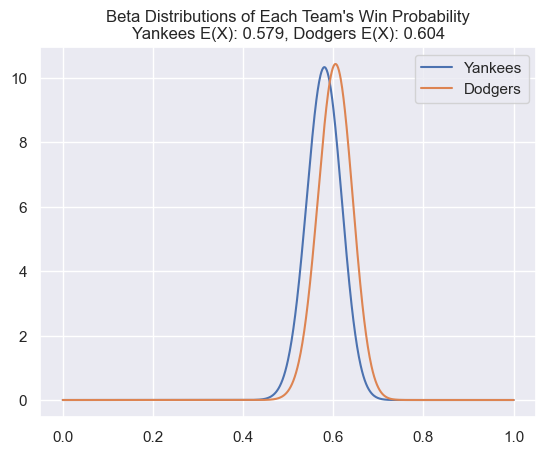

In [73]:
def my_plotter(continuous_distribution, **kwargs):
    """MPL Helper Function."""

    x = np.linspace(*continuous_distribution.support(), num=1000)

    y = continuous_distribution.pdf(x)
    
    ax = sns.lineplot(x=x, y=y, **kwargs)
    return ax

ax = my_plotter(bg.team_a_brv)
my_plotter(bg.team_b_brv, ax=ax)

title = f"Beta Distributions of Each Team's Win Probability\n{TEAM_A_NAME} E(X): {bg.team_a_brv.expect():.3f}, {TEAM_B_NAME} E(X): {bg.team_b_brv.expect():.3f}"

ax.set_title(title)
ax.legend(ax.lines, [TEAM_A_NAME, TEAM_B_NAME])

#### How I'm simulating home runs

I'm sampling from a poisson distribution for each team with $\lambda = AVG(HomeRunsPerGame)$. I'm using the regular season home run rate. This assumes no difference between home run rate in the regular season and the postseason. This should be verified with a test to determine whether the distribution of postseason homeruns is not statistically different than that of regular season home runs.

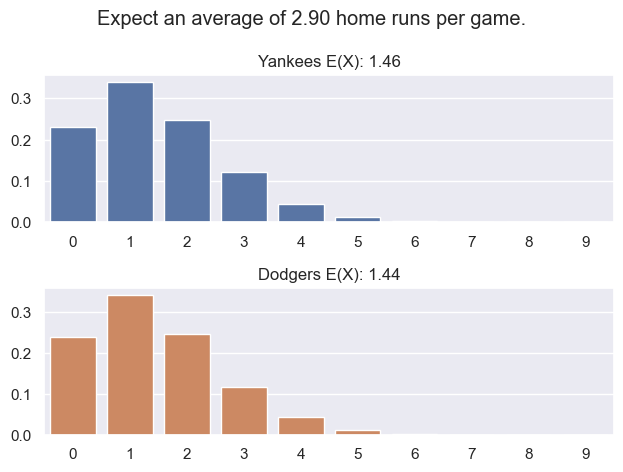

In [71]:
fig, axs = plt.subplots(2)


def plot_poisson(poisson_distribution, xmax=10, **kwargs):

    x_range = np.arange(0, xmax)
    ax = sns.barplot(x=x_range, y=poisson_distribution.pmf(x_range), **kwargs)
    return ax

team_a_hr_prv = stats.poisson(bg.team_a_home_runs_per_game)
team_b_hr_prv = stats.poisson(bg.team_b_home_runs_per_game)

plot_poisson(team_a_hr_prv, ax=axs[0])
axs[0].set_title(f'{TEAM_A_NAME} E(X): {team_a_hr_prv.expect():.2f}')

plot_poisson(team_b_hr_prv, ax=axs[1], color=sns.color_palette()[1])
axs[1].set_title(f'{TEAM_B_NAME} E(X): {team_b_hr_prv.expect():.2f}')

fig.suptitle(f'Expect an average of {team_a_hr_prv.expect() + team_b_hr_prv.expect():.2f} home runs per game.')
fig.tight_layout()

#### Baseball Series Simulator

In [10]:
class BaseballSeries:
    def __init__(self, game_simulator, n_games=7):
        self.game_simulator = game_simulator
        self.team_a_name = self.game_simulator.team_a_name
        self.team_b_name = self.game_simulator.team_b_name
        self.team_a_wins = 0
        self.team_b_wins = 0
        self.n_games = n_games

    @property
    def series_games(self):
        return pd.DataFrame(self._series_games)

    @series_games.setter
    def series_games(self, value):
        if hasattr(value, "__iter__"):
            self._series_games = value
        else:
            raise ValueError("Value must be iterable.")

    @series_games.deleter
    def series_games(self):
        del self._series_games

    @property
    def series_teams(self):
        return self.team_a_name, self.team_b_name

    @property
    def series_record(self):
        return self.team_a_wins, self.team_b_wins


    @property
    def series_winner(self):
        try:
            return self._series_winner
        except ValueError as err:
            print("Series winner is not yet determined.")

    @property
    def series_home_run_total(self):
        return self.series_games["HomeRunTotal"].sum()

    @series_winner.setter
    def series_winner(self, value):
        self._series_winner = value

    @series_winner.deleter
    def series_winner(self):
        del self._series_winner

    def team_name_lookup(self, team="a"):
        team_name_dict = {
            "a": self.team_a_name,
            "b": self.team_b_name,
        }

        return team_name_dict.get(team)

    def check_for_series_winner(self):
        for team in ["a", "b"]:
            team_won_series = self._series_win_majority(team)
            if team_won_series:
                self.series_winner = self.team_name_lookup(team)
                return self.series_winner

    def simulate_series(self):

        self._clear_simulated_values()

        games_played = []

        self.team_a_wins, self.team_b_wins = 0, 0

        while not self.check_for_series_winner():

            game = self.game_simulator.simulate_game()

            games_played.append(game)

            if game["Winner"] == self.team_a_name:
                self.team_a_wins += 1
            else:
                self.team_b_wins += 1

        self.series_games = games_played

        s = pd.Series(
            {
                "Winner": self.series_winner,
                "SeriesRecord": self.series_record,
                "SeriesHomeRuns": self.series_home_run_total,
            }
        )

        return s

    def _del_attr_if_exists(self, attr):
        if hasattr(self, attr):
            delattr(self, attr)

    def _clear_simulated_values(self):
        attributes = [
            'series_winner',
            'series_games',
            'team_a_wins',
            'team_b_wins',
        ]

        for a in attributes:
            self._del_attr_if_exists(a)

    def _series_win_majority(self, team="a"):
        wins = self.team_a_wins if team == "a" else self.team_b_wins
        return wins > self.n_games / 2

In [11]:
bs = BaseballSeries(bg)

#### Example Usage

In [12]:
bs.simulate_series()

Winner            Dodgers
SeriesRecord       (2, 4)
SeriesHomeRuns         18
dtype: object

### Simulating 100,000 World Series between these two teams.

In [ ]:
from pathlib import Path

n_simulations = 100_000
data_path = Path('../data/world-series-simulation.csv')

if not data_path.exists:    
    (
        pd.DataFrame(
            [bs.simulate_series() for i in range(n_simulations)]
        ).to_csv(data_path, index=False)
    )

### Loading the data and creating features.

We'll use some of these features later. Defining them in one location to declutter later cells.

In [248]:
# Promotion parameters
DONATION_PER_HOME_RUN = 25_000
DONATION_PER_TEXT = 10
DONATION_CEILING = 1_000_000

df = (
    pd.read_csv(data_path)
    .assign(
        SeriesRecord=lambda df: df.SeriesRecord.apply(eval),
        GamesPlayed=lambda df: df.SeriesRecord.apply(sum),
        donation_per_home_run=DONATION_PER_HOME_RUN,
        donation_ceiling=DONATION_CEILING,
        donation_per_text=DONATION_PER_TEXT,
        home_run_donation_total=lambda x: x.SeriesHomeRuns * x.donation_per_home_run,
        remainder_to_cap=lambda x: x.donation_ceiling - x.home_run_donation_total,
        texts_to_fill_cap=lambda x: x.remainder_to_cap / x.donation_per_text,
        proportion_hr_donations=lambda x: x.home_run_donation_total / x.donation_ceiling,
        ratio_hr_to_text_donations=lambda x: x.home_run_donation_total / x.remainder_to_cap,
    )
)

In [123]:
df

Winner SeriesRecord  SeriesHomeRuns  GamesPlayed  \
0      Dodgers       (1, 4)              12            5   
1      Dodgers       (1, 4)              10            5   
2      Yankees       (4, 1)              16            5   
3      Dodgers       (3, 4)              19            7   
4      Dodgers       (2, 4)              22            6   
...        ...          ...             ...          ...   
99995  Yankees       (4, 2)              17            6   
99996  Dodgers       (1, 4)              19            5   
99997  Dodgers       (2, 4)              20            6   
99998  Dodgers       (1, 4)              14            5   
99999  Dodgers       (2, 4)              15            6   

       donation_per_home_run  donation_ceiling  donation_per_text  \
0                      25000           1000000                 10   
1                      25000           1000000                 10   
2                      25000           1000000                 10   
3                      25000           1000000                 10   
4                      25000           1000000                 10   
...                      ...               ...                ...   
99995                  25000           1000000                 10   
99996                  25000           1000000                 10   
99997                  25000           1000000                 10   
99998                  25000           1000000                 10   
99999                  25000           1000000                 10   

       home_run_donation_total  remainder_to_cap  texts_to_fill_cap  \
0                       300000            700000            70000.0   
1                       250000            750000            75000.0   
2                       400000            600000            60000.0   
3                       475000            525000            52500.0   
4                       550000            450000            45000.0   
...                        ...               ...                ...   
99995                   425000            575000            57500.0   
99996                   475000            525000            52500.0   
99997                   500000            500000            50000.0   
99998                   350000            650000            65000.0   
99999                   375000            625000            62500.0   

       proportion_hr_donations  ratio_hr_to_text_donations  
0                        0.300                    0.428571  
1                        0.250                    0.333333  
2                        0.400                    0.666667  
3                        0.475                    0.904762  
4                        0.550                    1.222222  
...                        ...                         ...  
99995                    0.425                    0.739130  
99996                    0.475                    0.904762  
99997                    0.500                    1.000000  
99998                    0.350                    0.538462  
99999                    0.375                    0.600000  

[100000 rows x 12 columns]

## Exploratory Analysis

### How many games were played in the series?

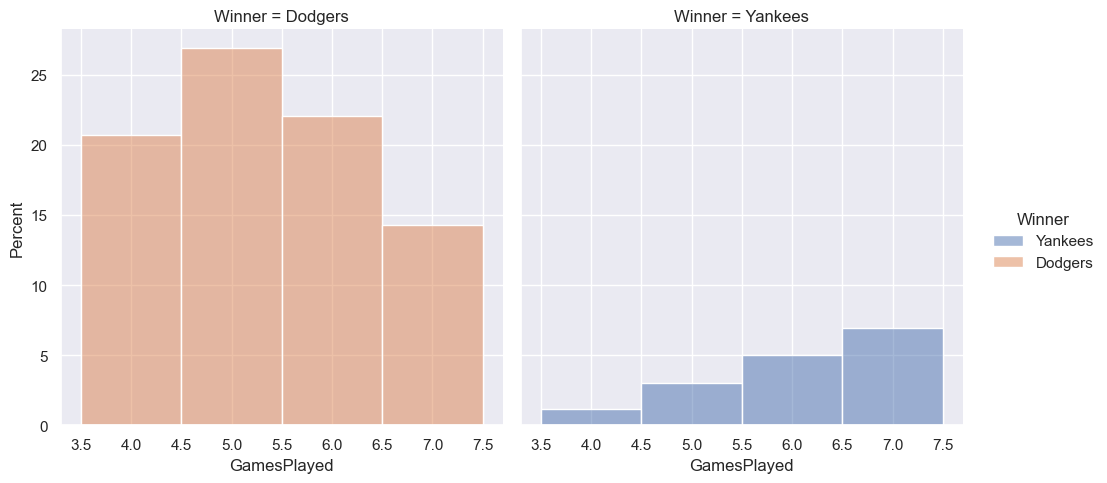

In [97]:
sns.displot(df, x='GamesPlayed', hue='Winner', col='Winner', hue_order=['Yankees', 'Dodgers'], stat='percent', discrete=True)

### How many total home runs do we expect in the series?

Our expected HR total is 15.86. The actual total was 16 (Yankees 7, Dodgers 9). Check it  out [here](https://www.baseball-reference.com/postseason/2024_WS.shtml).

In [100]:
shr = df.SeriesHomeRuns

<Axes: >

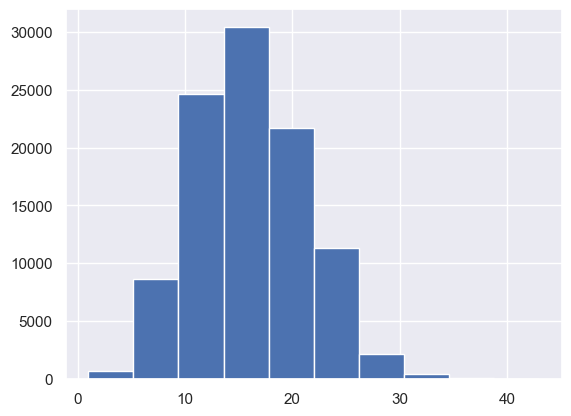

In [101]:
shr.hist()

In [103]:
from statsmodels.stats.descriptivestats import describe
describe(shr)

SeriesHomeRuns
nobs               100000.000000
missing                 0.000000
mean                   15.907920
std_err                 0.015942
upper_ci               15.939165
lower_ci               15.876675
std                     5.041239
iqr                     7.000000
iqr_normal              5.189108
mad                     4.039093
mad_normal              5.062252
coef_var                0.316901
range                  42.000000
max                    43.000000
min                     1.000000
skew                    0.367977
kurtosis                3.000043
jarque_bera          2256.789438
jarque_bera_pval        0.000000
mode                   15.000000
mode_freq               0.078260
median                 16.000000
1%                      6.000000
5%                      8.000000
10%                    10.000000
25%                    12.000000
50%                    16.000000
75%                    19.000000
90%                    23.000000
95%                    25.000000
99%                    29.000000

## Distribution of Series Home Runs

Since it's has huge influence on the donation, let's study the distribition of home runs hit.

The simulation generates enough data that we could query it directly.
What if we didn't have such complete data or wanted to extrapolate our sample to a theorized distribution, or wanted to leverage the methods defined in our stats packages?
We can conveniently fit a distribution to our sample and pass the learned parameters into an instance of the distribution.

### Manual Example

What proportion of the simulated series had `SeriesHomeRuns > 20`?

### Fitting a Poisson Distribution

In [221]:
bounds = {'mu': (0, 20)}
res = stats.fit(
    stats.poisson, shr.to_numpy(), bounds=bounds
)

fitted_prv = stats.poisson(*res.params)

print(res.message, res.params)

Optimization terminated successfully. FitParams(mu=np.float64(15.90791400978277), loc=np.float64(0.0))


<Axes: title={'center': 'Fitted $\\tt poisson$ PMF and Histogram'}, xlabel='k', ylabel='PMF'>

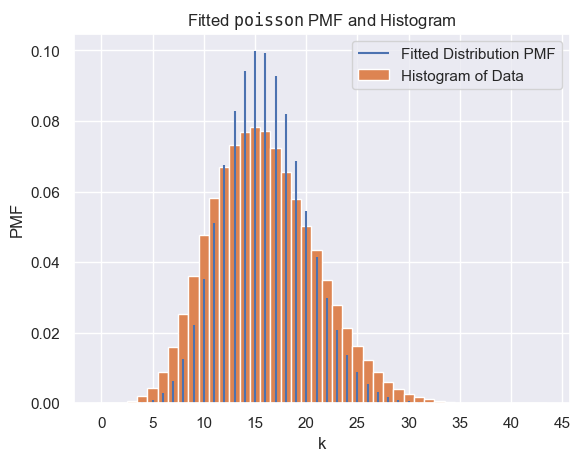

In [241]:
res.plot(plot_type='hist')

### Can we test whether this was the right theorized distribution?

In [240]:
stats.kstest(shr, shr.mean(), 'poisson')

KstestResult(statistic=np.float64(0.5055000000000001), pvalue=np.float64(0.9889999999999999), statistic_location=np.float64(15.90792), statistic_sign=np.int8(-1))

The sample likely came from this distribution.

In [223]:
len(df.query('SeriesHomeRuns > 20')) / len(df)

0.18227

### Fitted Distribution Example

In [224]:
fitted_prv.sf(20)

np.float64(0.1267419442640715)

## Determining T-Mobile's Assumptions

How many people watched the world series? What % of viewers do you expect a text from?
https://www.mlb.com/press-release/press-release-2024-world-series-drives-big-results-across-global-viewership-merchandise-sales-attendance-and-social-media#:~:text=The%20Fall%20Classic%20drew%20more,seven%2Dgame%202017%20World%20Series.

> The Fall Classic drew more than 30 million combined average viewers across North America and Asia. As reported by FOX, World Series viewership in the U.S. averaged 15.8 million across its platforms, a +67% increase versus last year and the most-watched series since the seven-game 2017 World Series.

We'll use the 15.8 Million USA number because these are the people likely targeted with the ads and have the most desire to donate to US Hurricane Relief.

Let's make some broad assumptions:
1. T-Mobile knew this and expected about 16 home runs to be hit.
    2. $1 Million dollars is a nice, big, round number to register as a donation cap.
3. Nearly all of the 30M were repeat viewers and there was negligible turnover from game to game. The portion of inconsistent viewership that would end up sending a text is negligible.

They probably wanted to set cap at a good sounding but realistic round number. And it's probably a good thing to set the cap at something realistic, since if they set it at an unrealistic target just to sound good and somebody ever followed up on the true number it could be a PR fiasco.

In [174]:
COMBINED_AVERAGE_VIEWERS = 30_000_000 # Worldwide viewership - just saving for reference.
US_VIEWERSHIP = 15_800_000

In [175]:
df.describe()[['SeriesHomeRuns', 'texts_to_fill_cap', 'proportion_hr_donations']]

SeriesHomeRuns  texts_to_fill_cap  proportion_hr_donations
count   100000.000000       100000.00000            100000.000000
mean        15.907920        60230.20000                 0.397698
std          5.041239        12603.09868                 0.126031
min          1.000000        -7500.00000                 0.025000
25%         12.000000        52500.00000                 0.300000
50%         16.000000        60000.00000                 0.400000
75%         19.000000        70000.00000                 0.475000
max         43.000000        97500.00000                 1.075000

Expecting ~16 home runs, ~60,000 texts would be required to fill to the cap, and assuming about 15.8 US viewers were expected, we can roughly guess what percent of viewership T-Mobile expected to send a text.

In [251]:
df.texts_to_fill_cap.mean() / US_VIEWERSHIP

np.float64(0.0038120379746835443)

0.3% of 15.8 million viewers would have to send a text for T-Mobile to reach their donation cap of $1 million.

## Appendix

### WS Opponents' Records

Here is the rudimentary code for scraping the records of teams that competed in the World Series.

TODO:
- Collect opponents records. (Blocked by rate limiting now.)
- Run a statistical test to see contingency results of Better Record by WS Winner

In [67]:
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import urllib

root = 'https://www.baseball-reference.com'
webpage = urllib.parse.urljoin(root, 'postseason/world-series.shtml')

n_previous_years = 20

df = (
    pd.read_html(webpage)[0]
    .assign(
        wins_al=lambda df: df['Wins'],
        wins_nl=lambda df: df['Wins.1'],
        ws_winner=lambda df: np.where(df.wins_al > df.wins_nl, df['AL Winner'], df['NL Winner']) 
    )
    .drop(columns=['Wins', 'Wins.1'])
    .loc[:119]
)

df

# r = requests.get(webpage)
# soup = BeautifulSoup(r.text)

# al_team_rows = [t for t in soup.find_all('td', {'data-stat': 'al_winner'})]
# nl_team_rows = [t for t in soup.find_all('td', {'data-stat': 'nl_winner'})]

# def get_team_record(html_table_row):

#     link = urllib.parse.urljoin(root, html_table_row.find('a')['href'])
    
#     r = requests.get(link)
#     soup = BeautifulSoup(r.text)
#     t = soup.find('div').text
#     s = re.search(r'(?is)Record\:.*(?P<wins>\d+)-(?P<losses>\d+)-(?P<ties>\d+),', t)

#     record = s.groupdict()
#     record['team'] = html_table_row.text
#     return record

# al_records = pd.DataFrame(get_team_record(r) for r in al_team_rows[:n_previous_years])
# nl_records = pd.DataFrame(get_team_record(r) for r in nl_team_rows[:n_previous_years])

HTTPError: HTTP Error 429: Too Many Requests

In [66]:
df

Year               AL Winner              NL Winner       Series MVP  \
0    2024        New York Yankees    Los Angeles Dodgers  Freddie Freeman   
1    2023           Texas Rangers   Arizona Diamondbacks     Corey Seager   
2    2022          Houston Astros  Philadelphia Phillies      Jeremy Peña   
3    2021          Houston Astros         Atlanta Braves      Jorge Soler   
4    2020          Tampa Bay Rays    Los Angeles Dodgers     Corey Seager   
..    ...                     ...                    ...              ...   
115  1909          Detroit Tigers     Pittsburgh Pirates              NaN   
116  1908          Detroit Tigers           Chicago Cubs              NaN   
117  1907          Detroit Tigers           Chicago Cubs              NaN   
118  1906       Chicago White Sox           Chicago Cubs              NaN   
119  1905  Philadelphia Athletics        New York Giants              NaN   

    wins_al wins_nl            ws_winner  
0         1       4  Los Angeles Dodgers  
1         4       1        Texas Rangers  
2         4       2       Houston Astros  
3         2       4       Atlanta Braves  
4         2       4  Los Angeles Dodgers  
..      ...     ...                  ...  
115       3       4   Pittsburgh Pirates  
116       1       4         Chicago Cubs  
117       0       4         Chicago Cubs  
118       4       2    Chicago White Sox  
119       1       4      New York Giants  

[120 rows x 7 columns]